In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim

In [71]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [72]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


In [73]:
BASE_PATH = "../Datasets/BrainTumor"
TRAIN_PATH = "../Datasets/BrainTumor/Training/"
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

In [74]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(0, translate=(0.15,0.15), scale=(0.9,1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   
                        std=[0.229, 0.224, 0.225])
])

In [75]:
print("="*60)
print("LOADED BRAIN TUMOR DATASET")
print("="*60)

full_dataset = datasets.ImageFolder(TRAIN_PATH)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
val_dataset.dataset = datasets.ImageFolder(TRAIN_PATH, val_transform)

LOADED BRAIN TUMOR DATASET


In [76]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

In [77]:
class_names = full_dataset.classes
print(f"\nClasses found: {class_names}")
print(f"Total training images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Num of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total training images: 4569
Total validation images: 1143
Num of training batches: 143
Number of validation batches: 36


In [78]:
print("="*60)
print("LOADING PRE-TRAINED RESNET50 MODEL")
print("="*60)

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_fltrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_fltrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}\n")

print("="*60)
print("MODEL ARCHITECTURE (Classifier Only)")
print("="*60)
print(model.fc)
print("="*60 + "\n")

LOADING PRE-TRAINED RESNET50 MODEL


d:\AKASH\PROJECTS\Multi_DL_Model\Backend\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AKASH\PROJECTS\Multi_DL_Model\Backend\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Total parameters: 24,691,012
Trainable parameters: 16,147,716
Frozen parameters: 8,543,296

MODEL ARCHITECTURE (Classifier Only)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=512, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.3, inplace=False)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): ReLU()
  (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=256, out_features=4, bias=True)
)



In [79]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=LEARNING_RATE,
                       weight_decay=1e-4)

schedular = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
)

In [80]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)     # ✅ Move this above the postfix
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})  # ✅ Now safe
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


In [81]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc='validate', leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


In [82]:
print("="*60)
print("STARTING TRAINING WITH TRANSFER LEARNING")
print("="*60 + "\n")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
patience_counter = 0
patience = 7  

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("="*40)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    schedular.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_brain_tumor_resnet50.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience})")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n✓ Early stopping triggered after {epoch+1} epochs")
        break


model.load_state_dict(best_model_wts)
print(f"\n{'='*60}")
print(f"TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}\n")


STARTING TRAINING WITH TRANSFER LEARNING


Epoch 1/50
Learning rate: 0.001000


Train Loss: 0.5072 | Train Acc: 81.81%
Val Loss:   0.2755 | Val Acc:   89.15%
✓ New best model saved! (Val Acc: 89.15%)

Epoch 2/50
Learning rate: 0.001000


Train Loss: 0.3283 | Train Acc: 87.90%
Val Loss:   0.2361 | Val Acc:   91.60%
✓ New best model saved! (Val Acc: 91.60%)

Epoch 3/50
Learning rate: 0.001000


Train Loss: 0.2655 | Train Acc: 90.44%
Val Loss:   0.1887 | Val Acc:   94.05%
✓ New best model saved! (Val Acc: 94.05%)

Epoch 4/50
Learning rate: 0.001000


Train Loss: 0.2500 | Train Acc: 91.51%
Val Loss:   0.1781 | Val Acc:   93.18%
No improvement (1/7)

Epoch 5/50
Learning rate: 0.001000


Train Loss: 0.2266 | Train Acc: 91.92%
Val Loss:   0.1474 | Val Acc:   95.01%
✓ New best model saved! (Val Acc: 95.01%)

Epoch 6/50
Learning rate: 0.001000


Train Loss: 0.2075 | Train Acc: 92.73%
Val Loss:   0.1627 | Val Acc:   93.96%
No improvement (1/7)

Epoch 7/50
Learning rate: 0.001000


Train Loss: 0.1957 | Train Acc: 93.28%
Val Loss:   0.1978 | Val Acc:   93.88%
No improvement (2/7)

Epoch 8/50
Learning rate: 0.001000


Train Loss: 0.1944 | Train Acc: 93.35%
Val Loss:   0.1464 | Val Acc:   94.58%
No improvement (3/7)

Epoch 9/50
Learning rate: 0.001000


Train Loss: 0.1847 | Train Acc: 93.43%
Val Loss:   0.1581 | Val Acc:   94.75%
No improvement (4/7)

Epoch 10/50
Learning rate: 0.001000


Train Loss: 0.1823 | Train Acc: 93.67%
Val Loss:   0.1286 | Val Acc:   95.19%
✓ New best model saved! (Val Acc: 95.19%)

Epoch 11/50
Learning rate: 0.001000


Train Loss: 0.1782 | Train Acc: 94.11%
Val Loss:   0.1373 | Val Acc:   94.84%
No improvement (1/7)

Epoch 12/50
Learning rate: 0.001000


Train Loss: 0.1431 | Train Acc: 95.01%
Val Loss:   0.1118 | Val Acc:   96.15%
✓ New best model saved! (Val Acc: 96.15%)

Epoch 13/50
Learning rate: 0.001000


Train Loss: 0.1600 | Train Acc: 94.16%
Val Loss:   0.1388 | Val Acc:   95.28%
No improvement (1/7)

Epoch 14/50
Learning rate: 0.001000


Train Loss: 0.1622 | Train Acc: 94.05%
Val Loss:   0.0990 | Val Acc:   95.89%
No improvement (2/7)

Epoch 15/50
Learning rate: 0.001000


Train Loss: 0.1482 | Train Acc: 94.77%
Val Loss:   0.1229 | Val Acc:   95.63%
No improvement (3/7)

Epoch 16/50
Learning rate: 0.001000


Train Loss: 0.1523 | Train Acc: 95.01%
Val Loss:   0.1275 | Val Acc:   94.49%
No improvement (4/7)

Epoch 17/50
Learning rate: 0.001000


Train Loss: 0.1404 | Train Acc: 95.34%
Val Loss:   0.1760 | Val Acc:   94.14%
No improvement (5/7)

Epoch 18/50
Learning rate: 0.001000


Train Loss: 0.1412 | Train Acc: 95.14%
Val Loss:   0.1170 | Val Acc:   95.63%
No improvement (6/7)

Epoch 19/50
Learning rate: 0.001000


Train Loss: 0.1271 | Train Acc: 95.43%
Val Loss:   0.1083 | Val Acc:   96.33%
✓ New best model saved! (Val Acc: 96.33%)

Epoch 20/50
Learning rate: 0.001000


Train Loss: 0.1166 | Train Acc: 96.08%
Val Loss:   0.1839 | Val Acc:   94.14%
No improvement (1/7)

Epoch 21/50
Learning rate: 0.001000


Train Loss: 0.1372 | Train Acc: 95.32%
Val Loss:   0.0840 | Val Acc:   97.38%
✓ New best model saved! (Val Acc: 97.38%)

Epoch 22/50
Learning rate: 0.001000


Train Loss: 0.1016 | Train Acc: 96.50%
Val Loss:   0.1089 | Val Acc:   96.24%
No improvement (1/7)

Epoch 23/50
Learning rate: 0.001000


Train Loss: 0.1304 | Train Acc: 95.62%
Val Loss:   0.1221 | Val Acc:   96.24%
No improvement (2/7)

Epoch 24/50
Learning rate: 0.001000


Train Loss: 0.1169 | Train Acc: 95.80%
Val Loss:   0.1307 | Val Acc:   95.71%
No improvement (3/7)

Epoch 25/50
Learning rate: 0.001000


Train Loss: 0.1193 | Train Acc: 95.95%
Val Loss:   0.0996 | Val Acc:   96.76%
No improvement (4/7)

Epoch 26/50
Learning rate: 0.001000


Train Loss: 0.1161 | Train Acc: 95.89%
Val Loss:   0.1747 | Val Acc:   95.19%
No improvement (5/7)

Epoch 27/50
Learning rate: 0.001000


Train Loss: 0.1337 | Train Acc: 95.80%
Val Loss:   0.1005 | Val Acc:   96.85%
No improvement (6/7)

Epoch 28/50
Learning rate: 0.001000


Train Loss: 0.1148 | Train Acc: 96.48%
Val Loss:   0.1074 | Val Acc:   96.15%
No improvement (7/7)

✓ Early stopping triggered after 28 epochs

TRAINING COMPLETE!
Best Validation Accuracy: 97.38%



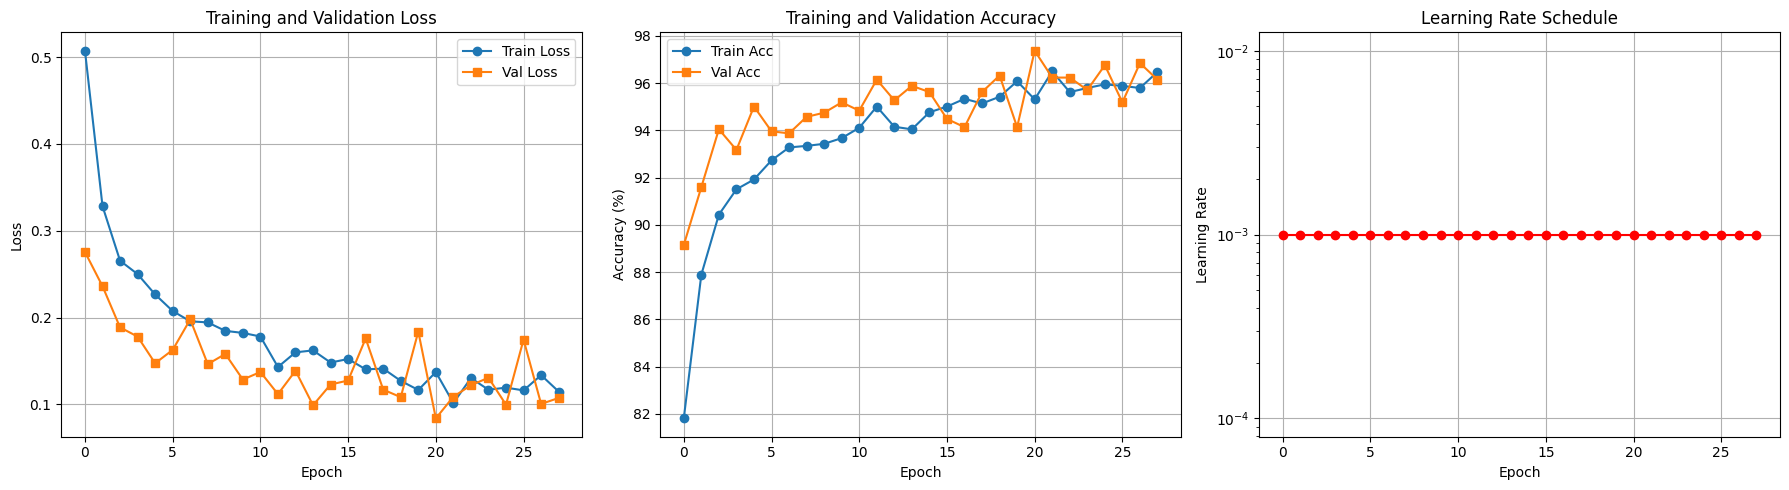

✓ Training plots saved as 'training_history_brain_tumor_resnet50.png'


In [84]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# Learning rate plot
axes[2].plot(history['lr'], color='red', marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_history_brain_tumor_resnet50.png', dpi=300)
plt.show()

print("✓ Training plots saved as 'training_history_brain_tumor_resnet50.png'")

In [85]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': schedular.state_dict() if schedular else None,
    'best_val_acc': best_val_acc,
    'history': history,
    'class_names': class_names,
    'model_architecture': str(model),
    'img_size': IMG_SIZE,
    'num_classes': NUM_CLASSES
}, 'best_brain_tumor_model_complete.pth')

print("\n✓ Complete model saved as 'best_brain_tumor_model_complete.pth'")


✓ Complete model saved as 'best_brain_tumor_model_complete.pth'
